# ROC and Distribution Analysis - Superkingdom classification

## Overview
This notebook modifies output CSV files generated by the Naive Bayes Classifier (NBC) after superkingdom classification and plots receiver-operating curves (ROC) with known/unknown distributions. Sequences in the training set were classified "known" and sequences not in the training set were classified as "unknown".
## Prerequisites
- Ensure all relevant NBC output CSV files are available locally.
- Concatenate appropriate output CSV files as needed before running this notebook. All file names should be in the format `{superkingdom}-{superkingdom}.csv`

File names can only contain these superkingdoms: `viruses`, `bacteria`, `archaea`, `eukaryota`


## Important Notes
- All output will be saved to your local environment.
- Do not use this notebook for lower level classifications. This is only for superkingdom classification

## Imports

In [82]:
import re
import pandas as pd
import os
import json
from collections import defaultdict
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

## Functions

In [69]:
def remove_duplicates(list_):
    seen = set()
    return [x for x in list_ if not (x in seen or seen.add(x))]

`remove_duplicates` takes in a list as input and removes duplicates from that list without changing the order.

In [70]:
def create_lookup(path):
    # load lookup json
    with open(path, 'r') as f:
        loaded_dict = json.load(f)

    flattened_values = list(itertools.chain.from_iterable(loaded_dict.values()))

    # create final lookup dictionary
    lookup = {value: key.split("|")[1] for key, values in loaded_dict.items() for value in values}
    
    return lookup
    
# usage
path_to_lookup_json = ''
lookup = create_lookup(path_to_lookup_json)

`create_lookup` loads the JSON file found in the `data` folder and creates a lookup dictionary. Replace `path_to_lookup_json` by the path to the JSON file.

In [104]:
def csv_modifier(csv_file):
        
    results = pd.read_csv(csv_file, names=['NCBI RefSeq', 'Predicted Species_ID', 'Logarithmic probability'])
    
    # remove number only rows
    mask = results['NCBI RefSeq'].apply(lambda x: not re.match(r'^\d+$', str(x)))
    results = results[mask]
    
    # get refseq 
    results['NCBI RefSeq striped'] = results['NCBI RefSeq'].str.split('_').str[:2].str.join('_')
    
    # remove trailing whitespaces
    results['NCBI RefSeq striped'] = results['NCBI RefSeq striped'].str.strip()
    
    results = pd.merge(
    results,
    lookup_table[['Species_ID', 'Superkingdom']],
    left_on='Predicted Species_ID',
    right_on='Species_ID',
    how='left'
    )

    # Rename the 'Superkingdom' column to 'Predicted Superkingdom'
    results = results.rename(columns={'Superkingdom': 'Predicted Superkingdom'})

    # Drop the extra 'Species_ID' column that came from the lookup dict
    results = results.drop(columns='Species_ID')
    
    # Use lookup to get the superkingdoms
    actual_superkingdom = [lookup.get(element, '') for element in results['NCBI RefSeq striped']]
    
    results["Actual Superkingdom"] = actual_superkingdom
    results["Actual Superkingdom"] = results["Actual Superkingdom"].str.strip()
    results["Predicted Superkingdom"] = results["Predicted Superkingdom"].str.strip()
    
    results['Accurate Prediction'] = (results["Predicted Superkingdom"] == results["Actual Superkingdom"])
    results = results.drop(columns='NCBI RefSeq striped')
    

    # classifies sequences as known or unknown
    def determine_superkingdom_status(row, target_superkingdoms):
        if row['Actual Superkingdom'] in target_superkingdoms:
            return 'Known'
        else:
            return 'Unknown'

    target_superkingdoms = csv_file.split('/')[-1][:-4].split("-")
    target_superkingdoms = [word.capitalize() for word in target_superkingdoms]

    results['Superkingdom Status'] = results[['Actual Superkingdom']].apply(lambda x: determine_superkingdom_status(x, target_superkingdoms), axis=1)

    # saves the modified results back to the original CSV file
    results.to_csv(f"{csv_file}", index=False)

    
    
    
# usage
path_to_csv = ''
csv_modifier(path_to_csv)

`csv_modifier` processes the raw output file for ROC curve generation. It adds four new columns to the file:

1. `Predicted Superkingdom`
2. `Actual Superkingdom`
3. `Accurate Prediction`
4. `Superkingdom Status`

Ensure all file names are in the format `{superkingdom}-{superkingdom}.csv` (similar to the training directories). Replace `path_to_csv` with the file path of the output file. 

#### Note: All modifications are saved to the original CSV file.

In [98]:
def roc(file, ax):

    # Read the CSV file
    df = pd.read_csv(file, low_memory=False)
    col = df.iloc[:, 1]

    # check for string numbers
    df = df[col.astype(str).str.contains(r'\d+', na=False)]
    # Extract columns
    y = pd.DataFrame(df['Superkingdom Status'])
    y.replace('Unknown', 0, inplace=True)
    y.replace('Known', 1, inplace=True)
    
    y_actual = y['Superkingdom Status']
    y_probs_log = df['Logarithmic probability']
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_actual, y_probs_log)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

`roc` takes in the **modified** CSV output file as input and generates a receiver-operating curve (ROC) using `scikit-learn`. Ensure all output files have been modified before running the code.

In [84]:
def distro(file, ax):
    data = pd.read_csv(file, low_memory=False)
    col = data.iloc[:, 1]  
    data = data[col.astype(str).str.contains(r'\d+', na=False)]
    probability_data = data.iloc[:, 2]
    label_data = data.iloc[:, 6]
    filtered_data = pd.DataFrame({"Log probability": probability_data, "Distribution": label_data})

    sns.histplot(data=filtered_data, x="Log probability", hue="Distribution", ax=ax, fill=True, palette={"Known": "darkorange", "Unknown": "violet"}, hue_order=["Unknown", "Known"], bins=1700)

    mode = filtered_data["Log probability"].mode().iloc[0]
    margin = 250  
    ax.set_xlim(mode - margin, mode + margin)

    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")

This function generates histograms showing the known/unknown distributions. The x-axis is adjusted to focus on the range near the mode of the distribution for better visibility. Adjust the `margin` parameter to fine-tune the x-axis range as needed for optimal visualization.

### Example Usage: Plotting ROC curves and histograms

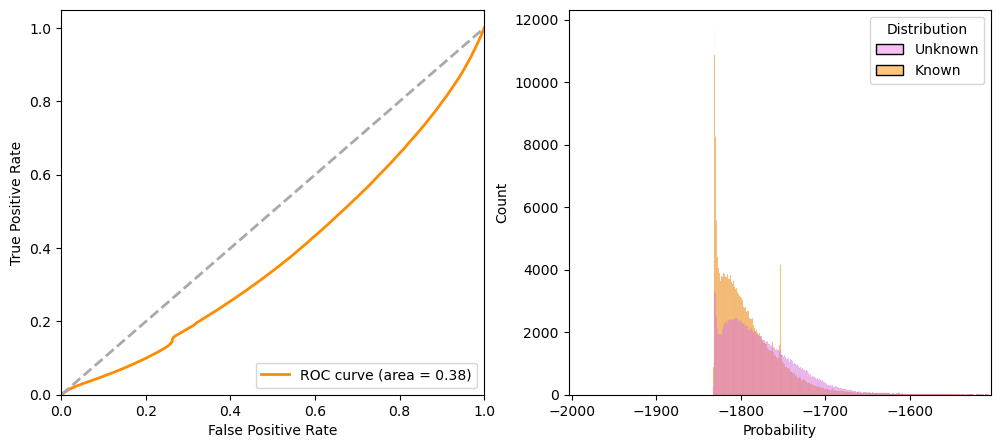

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# replace with file path
file_path = ''
roc(file_path, ax[0])
distro(file_path, ax[1])